## 1. Setup and Get Data (Python 3.10.11)

### 1.1 Install Dependencies and Setup

In [1]:
!pip install --default-timeout=1000 labelImg tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib albumentations

     ---------------------------------------- 0.0/247.7 kB ? eta -:--:--
     --------------- ---------------------- 102.4/247.7 kB 2.0 MB/s eta 0:00:01
     -------------------------------------  245.8/247.7 kB 3.0 MB/s eta 0:00:01
     -------------------------------------- 247.7/247.7 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached tensorflow-2.8.0-cp310-cp310-win_amd64.whl.metadata (2.9 kB)
  Using cached tensorflow_gpu-2.8.0-cp310-cp310-win_amd64.whl.metadata (2.9 kB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached m

In [2]:
!pip install protobuf==3.20.0

  Using cached protobuf-3.20.0-cp310-cp310-win_amd64.whl.metadata (698 bytes)
Using cached protobuf-3.20.0-cp310-cp310-win_amd64.whl (903 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.26.1
    Uninstalling protobuf-5.26.1:
      Successfully uninstalled protobuf-5.26.1


In [3]:
!pip list

Package                      Version
---------------------------- -------------------
absl-py                      2.1.0
albumentations               1.4.7
annotated-types              0.6.0
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.3.3
certifi                      2024.2.2
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
exceptiongroup               1.2.1
executing                    2.0.1
flatbuffers                  24.3.25
fonttools                    4.51.0
gast                         0.5.4
google-auth                  2.29.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.63.0
h5py                         3.11.0
idna                         3.7
imageio                      2.

### 1.2 Collect Image Using OpenCV

In [4]:
import os
import time
import cv2

In [5]:
# Define the classes and their corresponding directory names
class_labels = [
    "anorganik",
    "botol_kaca",
    "botol_plastik",
    "kantong_sampah",
    "karton",
    "kertas",
    "organik",
    "plastik",
    "tong_sampah",
]
# class_labels = ["anorganik"]

In [6]:
# Create directories for each class if they don't exist
for class_label in class_labels:
    class_image_dir = os.path.join("data", "images", class_label)
    class_label_dir = os.path.join("data", "labels", class_label)
    if not os.path.exists(class_image_dir):
        os.makedirs(class_image_dir)
    if not os.path.exists(class_label_dir):
        os.makedirs(class_label_dir)

In [7]:
# Function to get the last file number for a given class
def get_last_file_number(class_dir):
    files = os.listdir(class_dir)
    numbers = [int(f.split("_")[-1].split(".")[0]) for f in files if f.endswith(".jpg")]
    if numbers:
        return max(numbers)
    else:
        return 0

In [37]:
# Initialize OpenCV VideoCapture
cap = cv2.VideoCapture(1)

In [38]:
# Collect images
number_images_per_class = 30

for class_label in class_labels:
    print(f"Collecting images for class: {class_label}")
    class_dir = os.path.join("data", "images", class_label)
    last_file_number = get_last_file_number(class_dir)

    for imgnum in range(number_images_per_class):
        print(f"Collecting image {imgnum}")

        # Read a frame from the camera
        ret, frame = cap.read()

        # Get the next file number
        next_file_number = last_file_number + imgnum + 1

        # Write the image with the formatted filename
        imgname = os.path.join(class_dir, f"{class_label}_{next_file_number}.jpg")
        cv2.imwrite(imgname, frame)

        cv2.imshow("Frame", frame)
        time.sleep(0.3)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [9]:
!labelImg

## 2. Review Dataset and Build Image Loading Function

### 2.1 Import TensorFlow and Dependencies

In [10]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [11]:
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TensorFlow Data

In [14]:
# images = tf.data.Dataset.list_files("data\\images\\*.jpg", shuffle=False)

# Define the base directory containing subdirectories for each class
base_dir = "data/images"

# List all subdirectories (each representing a class)
class_directories = [
    os.path.join(base_dir, d)
    for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
]

# Create a list of file patterns for each class
file_patterns = [os.path.join(class_dir, "*.jpg") for class_dir in class_directories]

# Create a dataset containing file paths for all images in each class
datasets = [
    tf.data.Dataset.list_files(pattern, shuffle=False) for pattern in file_patterns
]

In [15]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [16]:
# images = images.map(load_image)

# Map the load_image function to each dataset
loaded_images_datasets = [dataset.map(load_image) for dataset in datasets]

In [17]:
# images.as_numpy_iterator().next()

# Example: Load images from the first class
images_from_first_class = loaded_images_datasets[0]

In [18]:
# Print an example image
for img in images_from_first_class.take(1):
    print(img)

tf.Tensor(
[[[ 32  31  27]
  [ 32  31  27]
  [ 32  31  27]
  ...
  [  6   4   5]
  [  6   4   5]
  [  5   3   4]]

 [[ 32  31  27]
  [ 32  31  27]
  [ 32  31  27]
  ...
  [  6   4   5]
  [  6   4   5]
  [  5   3   4]]

 [[ 32  31  27]
  [ 32  31  27]
  [ 32  31  27]
  ...
  [  6   4   5]
  [  6   4   5]
  [  5   3   4]]

 ...

 [[125 129 130]
  [125 129 130]
  [125 129 130]
  ...
  [ 37  36  32]
  [ 37  36  32]
  [ 37  36  32]]

 [[125 129 130]
  [125 129 130]
  [125 129 130]
  ...
  [ 37  36  32]
  [ 37  36  32]
  [ 37  36  32]]

 [[126 130 131]
  [126 130 131]
  [126 130 131]
  ...
  [ 37  36  32]
  [ 37  36  32]
  [ 37  36  32]]], shape=(480, 640, 3), dtype=uint8)


### 2.4 View Raw Images with Matplotlib

In [20]:
# image_generator = images.batch(4).as_numpy_iterator()

In [21]:
# plot_images = image_generator.next()

In [89]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# for idx, image in enumerate(plot_images):
#     ax[idx].imshow(image)
# plt.show()

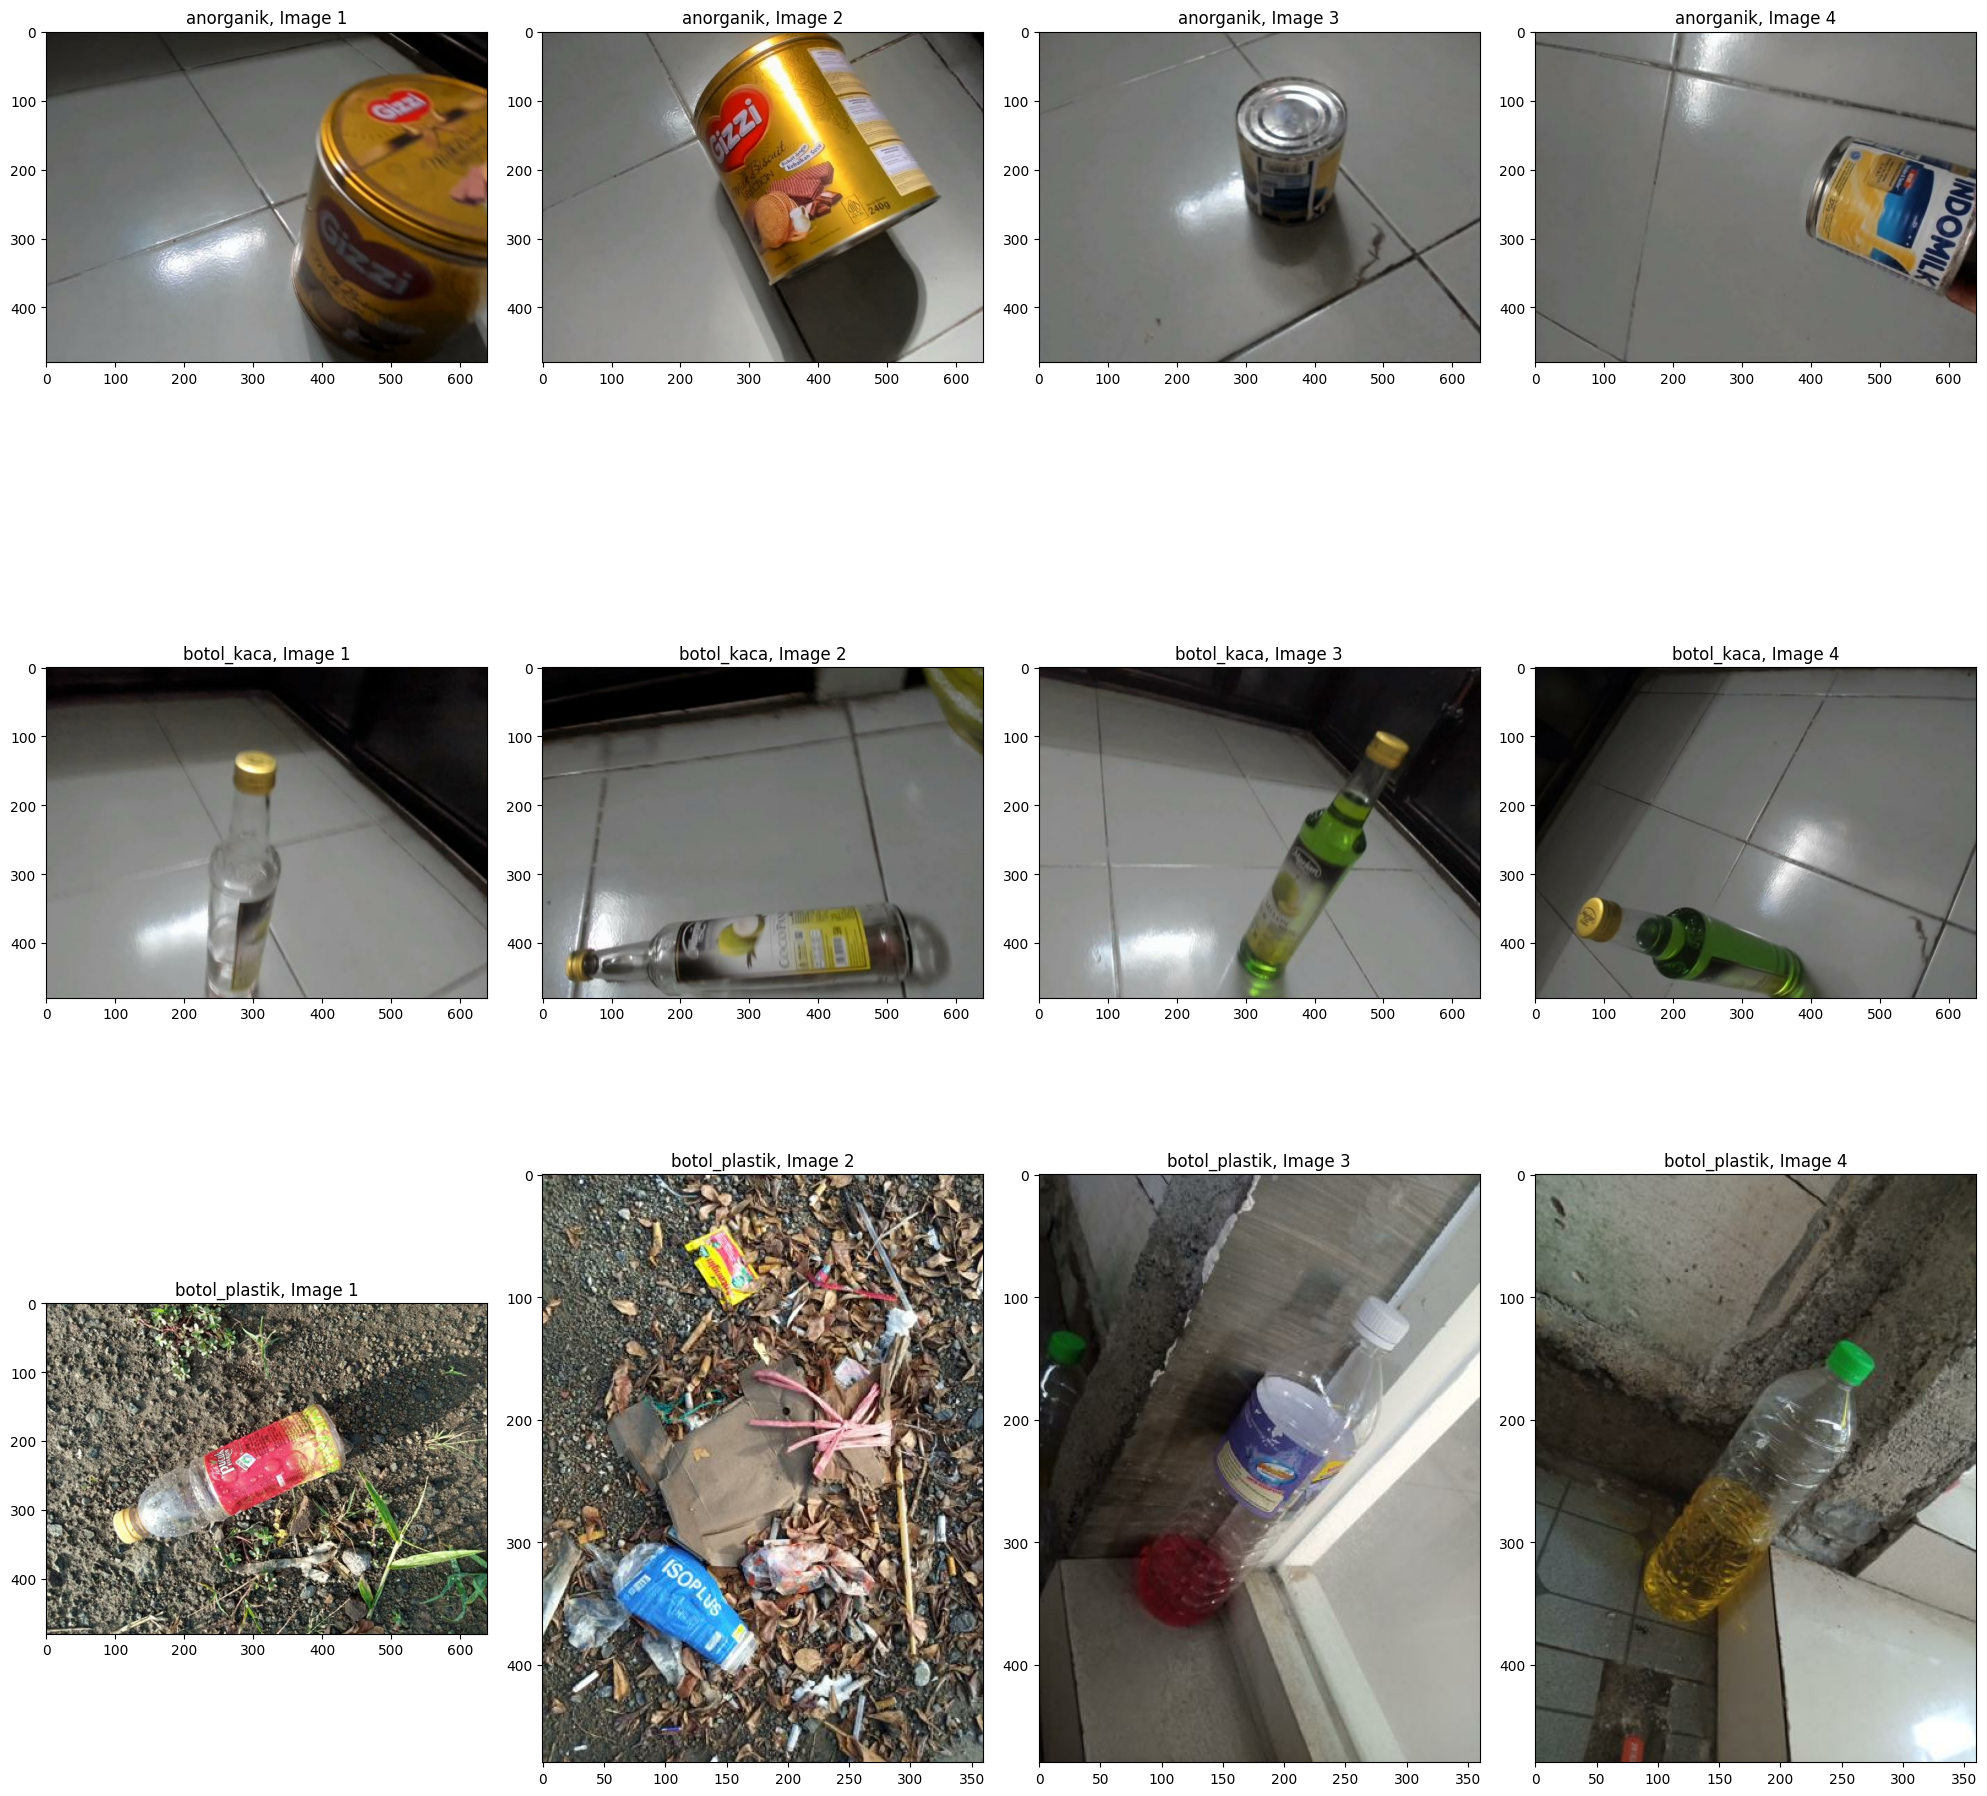

In [19]:
num_images_per_class = 4

class_names = [
    "anorganik",
    "botol_kaca",
    "botol_plastik",
    "kantong_sampah",
    "karton",
    "kertas",
    "organik",
    "plastik",
    "tong_sampah",
]

fig, axs = plt.subplots(
    len(loaded_images_datasets), num_images_per_class, figsize=(20, 20)
)

# Iterate over each dataset and plot images
for i, (dataset, class_name) in enumerate(zip(loaded_images_datasets, class_names)):
    # Take the first `num_images_per_class` images from the dataset
    image_generator = dataset.take(num_images_per_class).as_numpy_iterator()

    # Plot each image
    for j, image in enumerate(image_generator):
        axs[i, j].imshow(image)
        axs[i, j].set_title(f"{class_name}, Image {j+1}")

plt.tight_layout()
plt.show()

## 3. Partition Unaugmented Data

### 3.1 Split Data into Train, Val, and Test

In [ ]:
import shutil
import random

In [21]:
# Define paths
data_dir = "data/images"
train_dir = "data/train"
val_dir = "data/val"
test_dir = "data/test"

# Create train, val, and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of class directories
class_dirs = [
    d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))
]

In [367]:
# Iterate over each class directory
for class_dir in class_dirs:
    # Create train, val, and test directories for each class if they don't exist
    os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)

    # Get list of image files for the current class
    image_files = os.listdir(os.path.join(data_dir, class_dir))

    # Shuffle the image files
    random.shuffle(image_files)

    # Calculate split indices
    num_images = len(image_files)
    train_split = int(0.7 * num_images)
    val_split = int(0.2 * num_images)

    # Split the image files into train, val, and test sets
    train_images = image_files[:train_split]
    val_images = image_files[train_split : train_split + val_split]
    test_images = image_files[train_split + val_split :]

    # Copy images to train, val, and test directories
    for img in train_images:
        src = os.path.join(data_dir, class_dir, img)
        dst = os.path.join(train_dir, class_dir, "images", img)
        shutil.copy(src, dst)

    for img in val_images:
        src = os.path.join(data_dir, class_dir, img)
        dst = os.path.join(val_dir, class_dir, "images", img)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(data_dir, class_dir, img)
        dst = os.path.join(test_dir, class_dir, "images", img)
        shutil.copy(src, dst)

### 3.2 Move the Matching Labels

In [ ]:
for class_dir in class_dirs:
    for folder in ["train", "val", "test"]:
        for file in os.listdir(os.path.join("data", folder, class_dir, "images")):
            filename = file.split(".")[0] + ".json"
            existing_filepath = os.path.join("data", "labels", class_dir, filename)

            if os.path.exists(existing_filepath):
                new_filepath = os.path.join(
                    "data", folder, class_dir, "labels", filename
                )
                shutil.copy(existing_filepath, new_filepath)

## 4. Apply Image Augmentation on Images and Labels Using Albumentations

### 4.1 Setup Albumentations Transform

In [22]:
import albumentations as alb

In [23]:
augmentor = alb.Compose(
    [
        alb.RandomCrop(width=350, height=350),
    ],
    bbox_params=alb.BboxParams(format="albumentations", label_fields=["class_labels"]),
)

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [24]:
img = cv2.imread(os.path.join("data", "images", "anorganik", "anorganik_18.jpg"))

In [25]:
with open(os.path.join("data", "labels", "anorganik", "anorganik_18.json"), "r") as f:
    label = json.load(f)

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [26]:
# # coords = [0,0,0,0]
# # coords[0] = label["shapes"][0]["points"][0][0]
# # coords[1] = label["shapes"][0]["points"][0][1]
# # coords[2] = label["shapes"][0]["points"][1][0]
# # coords[3] = label["shapes"][0]["points"][1][1]

# Initialize an empty dictionary
all_coords_by_class = {}

# Iterate over each shape in the label
for shape in label["shapes"]:
    # Get the class label
    class_label = shape["label"]

    # Get the bounding box coordinates
    coords = [0, 0, 0, 0]
    coords = [shape["points"][0], shape["points"][1]]

    # If the class label is not in the dictionary, add it
    if class_label not in all_coords_by_class:
        all_coords_by_class[class_label] = []

    # Append the coordinates to the list for this class label
    all_coords_by_class[class_label].append(coords)

In [27]:
all_coords_by_class

{'anorganik': [[[220.8906882591093, 237.77327935222672],
   [275.54655870445345, 336.15384615384613]],
  [[278.7854251012146, 251.53846153846155],
   [345.1821862348178, 310.2429149797571]],
  [[66.23481781376523, 330.48582995951415],
   [180.40485829959516, 389.59514170040484]]],
 'plastik': [[[289.31174089068827, 16.720647773279378],
   [359.0, 125.81378637895588]],
  [[297.004048582996, 174.61538461538464],
   [354.8987854251012, 241.417004048583]]]}

In [28]:
# Normalize bounding box coordinates
image_height, image_width = img.shape[:2]
for class_name in all_coords_by_class:
    for bbox in all_coords_by_class[class_name]:
        bbox[0][0] /= image_width
        bbox[0][1] /= image_height
        bbox[1][0] /= image_width
        bbox[1][1] /= image_height

In [29]:
all_coords_by_class

{'anorganik': [[[0.6135852451641925, 0.49536099865047234],
   [0.7654071075123707, 0.7003205128205128]],
  [[0.7744039586144851, 0.5240384615384616],
   [0.9588394062078271, 0.6463394062078273]],
  [[0.18398560503823674, 0.6885121457489878],
   [0.5011246063877643, 0.8116565452091767]]],
 'plastik': [[[0.8036437246963563, 0.0348346828609987],
   [0.9972222222222222, 0.2621120549561581]],
  [[0.8250112460638778, 0.3637820512820513],
   [0.9858299595141701, 0.5029520917678812]]]}

### 4.4 Apply Augmentations and View Results

In [30]:
# Extract class labels from your dataset
class_labels = list(all_coords_by_class.keys())

In [31]:
class_labels

['anorganik', 'plastik']

In [32]:
# Prepare bboxes and class_labels for albumentations
bboxes = []
class_labels = []
for class_name in all_coords_by_class:
    for bbox in all_coords_by_class[class_name]:
        bboxes.append([bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1], class_name])
        class_labels.append(class_name)

In [33]:
print(bboxes)
print(class_labels)

[[0.6135852451641925, 0.49536099865047234, 0.7654071075123707, 0.7003205128205128, 'anorganik'], [0.7744039586144851, 0.5240384615384616, 0.9588394062078271, 0.6463394062078273, 'anorganik'], [0.18398560503823674, 0.6885121457489878, 0.5011246063877643, 0.8116565452091767, 'anorganik'], [0.8036437246963563, 0.0348346828609987, 0.9972222222222222, 0.2621120549561581, 'plastik'], [0.8250112460638778, 0.3637820512820513, 0.9858299595141701, 0.5029520917678812, 'plastik']]
['anorganik', 'anorganik', 'anorganik', 'plastik', 'plastik']


In [34]:
# augmented = augmentor(image=img, bboxes=[coords], class_labels=["face"])

augmented = augmentor(image=img, bboxes=bboxes, class_labels=class_labels)

In [35]:
augmented["bboxes"]

[(0.6139733950260265,
  0.45363794100636207,
  0.770133024869867,
  0.7347252747252747,
  'anorganik'),
 (0.7793869288606132,
  0.492967032967033,
  0.969091960670908,
  0.6606940427993059,
  'anorganik'),
 (0.17209947946790066,
  0.718530942741469,
  0.49829959514170047,
  0.8874146905725853,
  'anorganik'),
 (0.8094621168305379, 0.0, 1.0, 0.13375367536844537, 'plastik'),
 (0.83144013880856,
  0.27318681318681326,
  0.9968536726431463,
  0.4640485829959515,
  'plastik')]

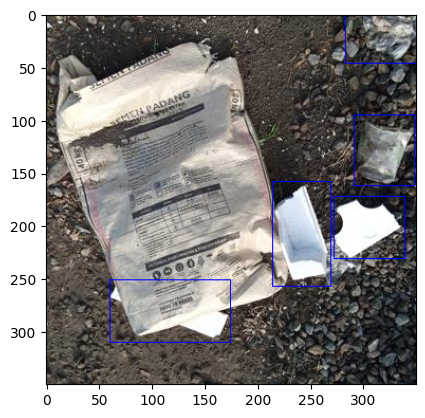

In [36]:
# cv2.rectangle(
#     augmented["image"],
#     tuple(np.multiply(augmented["bboxes"][0][:2], [450,450]).astype(int)),
#     tuple(np.multiply(augmented["bboxes"][0][2:], [450,450]).astype(int)),
#     (255,0,0),
#     1
# )

# plt.imshow(augmented["image"])

# Visualize the augmented image
for bbox, class_label in zip(augmented["bboxes"], augmented["class_labels"]):
    cv2.rectangle(
        augmented["image"],
        tuple(
            np.multiply(bbox[:2], [350, 350]).astype(int)
        ),  # Use only the first two elements of bbox
        tuple(
            np.multiply(bbox[2:4], [350, 350]).astype(int)
        ),  # Use only the third and fourth elements of bbox
        (255, 0, 0),
        1,
    )

plt.imshow(cv2.cvtColor(augmented["image"], cv2.COLOR_BGR2RGB))
plt.show()

## 5. Build and Run Augmentation

### 5.1 Run Augmentation

In [ ]:
# for partition in ["train", "val", "test"]:
#     for image in os.listdir(os.path.join("data", partition, "images")):
#         img = cv2.imread(os.path.join("data", partition, "images", image))
#         coords = [0,0,0.00001,0.00001]
#         label_path = os.path.join("data", partition, "labels", f"{image.split('.')[0]}.json")

#         if os.path.exists(label_path):
#             with open(label_path, "r") as f:
#                 label = json.load(f)
                
#             coords[0] = label["shapes"][0]["points"][0][0]
#             coords[1] = label["shapes"][0]["points"][0][1]
#             coords[2] = label["shapes"][0]["points"][1][0]
#             coords[3] = label["shapes"][0]["points"][1][1]
#             coords = list(np.divide(coords, [640,480,640,480]))

#         try:
#             for x in range(60):
#                 augmented = augmentor(image=img, bboxes=[coords], class_labels=["face"])
#                 cv2.imwrite(os.path.join("aug_data", partition, "images", f"{image.split('.')[0]}.{x}.jpg"), augmented['image'])

#                 annotation = {}
#                 annotation["image"] = image

#                 if os.path.exists(label_path):
#                     if len(augmented["bboxes"]) == 0:
#                         annotation["bbox"] = [0,0,0,0]
#                         annotation["class"] = 0
#                     else:
#                         annotation["bbox"] = augmented["bboxes"][0]
#                         annotation["class"] = 1
#                 else:
#                     annotation["bbox"] = [0,0,0,0]
#                     annotation["class"] = 0

#                 with open(os.path.join("aug_data", partition, "labels", f"{image.split('.')[0]}.{x}.json"), "w") as f:
#                     json.dump(annotation, f)

#         except Exception as e:
#             print(e)

In [37]:
# Define your data directories
data_partitions = ["train", "val", "test"]
base_dir = "aug_data"

In [ ]:
# Initialize an empty dictionary
all_coords_by_class = {}

for class_dir in class_dirs:

    # Iterate over each partition (train, val, test)
    for partition in data_partitions:
        # Set up directories for images and labels in the current partition
        image_dir = os.path.join(base_dir, partition, class_dir, "images")
        label_dir = os.path.join(base_dir, partition, class_dir, "labels")
        os.makedirs(image_dir, exist_ok=True)
        os.makedirs(label_dir, exist_ok=True)

        # Loop through images in the current partition
        for image_file in os.listdir(
            os.path.join("data", partition, class_dir, "images")
        ):
            # Load image
            img = cv2.imread(
                os.path.join("data", partition, class_dir, "images", image_file)
            )

            # Load label if exists
            label_path = os.path.join(
                "data",
                partition,
                class_dir,
                "labels",
                f"{image_file.split('.')[0]}.json",
            )

            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    label = json.load(f)

                # Extract bounding box coordinates
                # Iterate over each shape in the label
                for shape in label["shapes"]:
                    # Get the class label
                    class_label = shape["label"]

                    # Get the bounding box coordinates
                    coords = [0, 0, 0.00001, 0.00001]
                    coords = [shape["points"][0], shape["points"][1]]

                    # If the class label is not in the dictionary, add it
                    if class_label not in all_coords_by_class:
                        all_coords_by_class[class_label] = []

                    # Append the coordinates to the list for this class label
                    all_coords_by_class[class_label].append(coords)

                # Normalize bounding box coordinates
                image_height, image_width = img.shape[:2]
                for class_name in all_coords_by_class:
                    for bbox in all_coords_by_class[class_name]:
                        bbox[0][0] /= image_width
                        bbox[0][1] /= image_height
                        bbox[1][0] /= image_width
                        bbox[1][1] /= image_height

            try:
                # Apply augmentation multiple times
                for x in range(60):
                    # Perform augmentation
                    augmented = augmentor(
                        image=img, bboxes=bboxes, class_labels=class_labels
                    )

                    # Save augmented image
                    cv2.imwrite(
                        os.path.join(image_dir, f"{image_file.split('.')[0]}.{x}.jpg"),
                        augmented["image"],
                    )

                    # Create annotation dictionary
                    annotation = {"image": image_file}
                    if os.path.exists(label_path):
                        if len(augmented["bboxes"]) == 0:
                            annotation["bbox"] = [0, 0, 0, 0]
                            annotation["class"] = 0
                        else:
                            annotation["bbox"] = augmented["bboxes"][0]
                            annotation["class"] = 1
                    else:
                        annotation["bbox"] = [0, 0, 0, 0]
                        annotation["class"] = 0

                    # Save annotation as JSON
                    with open(
                        os.path.join(label_dir, f"{image_file.split('.')[0]}.{x}.json"),
                        "w",
                    ) as f:
                        json.dump(annotation, f)

            except Exception as e:
                print(e)

### 5.2 Load Augmented Images to TensorFlow Dataset

In [ ]:
# train_images = tf.data.Dataset.list_files("aug_data\\train\\anorganik\\images\\*.jpg", shuffle=False)
# train_images = train_images.map(load_image)
# train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
# train_images = train_images.map(lambda x: x/255)

In [ ]:
# val_images = tf.data.Dataset.list_files("aug_data\\val\\anorganik\\images\\*.jpg", shuffle=False)
# val_images = val_images.map(load_image)
# val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
# val_images = val_images.map(lambda x: x/255)

In [ ]:
# test_images = tf.data.Dataset.list_files("aug_data\\test\\anorganik\\images\\*.jpg", shuffle=False)
# test_images = test_images.map(load_image)
# test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
# test_images = test_images.map(lambda x: x/255)

In [40]:
# Load augmented images for all classes
train_images = []
val_images = []
test_images = []

In [41]:
for class_dir in class_dirs:
    # List all augmented image directories for each class
    augmented_image_dirs = [
        os.path.join("aug_data", partition, class_dir, "images")
        for partition in data_partitions
    ]

    # Create a dataset containing file paths for all augmented images in each class
    augmented_datasets = [
        tf.data.Dataset.list_files(os.path.join(dir, "*.jpg"), shuffle=False)
        for dir in augmented_image_dirs
    ]

    # Map the load_image function to each dataset
    loaded_images_datasets = [
        dataset.map(load_image) for dataset in augmented_datasets
    ]

    # Separate datasets for training, validation, and testing
    train_images.append(loaded_images_datasets[0])
    val_images.append(loaded_images_datasets[1])
    test_images.append(loaded_images_datasets[2])

In [42]:
# Example: Load augmented images from the first class
train_augmented_images_from_first_class = train_images[0]
val_augmented_images_from_first_class = val_images[0]
test_augmented_images_from_first_class = test_images[0]

for img in train_augmented_images_from_first_class.take(1):
    print(img)

for img in val_augmented_images_from_first_class.take(1):
    print(img)

for img in test_augmented_images_from_first_class.take(1):
    print(img)

tf.Tensor(
[[[111 110 108]
  [111 110 108]
  [112 111 109]
  ...
  [141 140 136]
  [141 140 138]
  [142 141 139]]

 [[108 107 105]
  [108 107 105]
  [109 108 106]
  ...
  [143 142 138]
  [142 141 139]
  [142 141 139]]

 [[107 106 104]
  [108 107 105]
  [109 108 106]
  ...
  [143 142 138]
  [143 142 140]
  [142 141 139]]

 ...

 [[116 116 114]
  [116 116 114]
  [116 116 114]
  ...
  [129 128 126]
  [128 127 125]
  [128 127 125]]

 [[116 116 114]
  [116 116 114]
  [116 116 114]
  ...
  [129 128 126]
  [128 127 125]
  [128 127 125]]

 [[116 116 114]
  [116 116 114]
  [116 116 114]
  ...
  [129 128 126]
  [128 127 125]
  [128 127 125]]], shape=(350, 350, 3), dtype=uint8)
tf.Tensor(
[[[ 49  48  46]
  [ 52  51  49]
  [ 52  51  49]
  ...
  [110 111 106]
  [110 111 106]
  [110 111 106]]

 [[ 50  49  47]
  [ 53  52  50]
  [ 53  52  50]
  ...
  [110 111 106]
  [110 111 106]
  [110 111 106]]

 [[ 51  50  48]
  [ 53  52  50]
  [ 54  53  51]
  ...
  [111 111 109]
  [111 111 109]
  [111 111 109]]

 

## 6. Prepare Labels

### 6.1 Build Label Loading Function

In [43]:
def load_labels(label_path):
    label_path = label_path.numpy().decode("utf-8")
    with open(label_path, "r") as f:
        data = json.load(f)

    class_labels = []
    bboxes = []
    if "shapes" in data:  # Check if 'shapes' key exists
        for shape in data["shapes"]:
            class_label = shape["label"]
            bbox = shape["points"]
            # Flatten bbox
            bbox_flat = [coord for point in bbox for coord in point]
            class_labels.append(class_label)
            bboxes.append(bbox_flat)

    # If no bounding boxes were added, add a default one
    if not bboxes:
        bboxes.append([0, 0, 0, 0])
        class_labels.append(-1)

    return np.array(class_labels), np.array(bboxes)


def tf_load_labels(label_path):
    bboxes = tf.py_function(load_labels, [label_path], tf.float32)
    bboxes.set_shape([None, 5])  # Each bounding box has 4 coordinates and a class label

    return bboxes

### 6.2 Load Labels to TensorFlow Dataset

In [136]:
# train_labels = tf.data.Dataset.list_files("aug_data\\train\\anorganik\\labels\\*.json", shuffle=False)
# train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [137]:
# val_labels = tf.data.Dataset.list_files("aug_data\\val\\anorganik\\labels\\*.json", shuffle=False)
# val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [138]:
# test_labels = tf.data.Dataset.list_files("aug_data\\test\\anorganik\\labels\\*.json", shuffle=False)
# test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [44]:
# Load labels for all classes
train_labels = []
val_labels = []
test_labels = []

In [45]:
for class_dir in class_dirs:
    # List all augmented label directories for each class
    augmented_label_dirs = [
        os.path.join("aug_data", partition, class_dir, "labels")
        for partition in data_partitions
    ]

    # Create a dataset containing file paths for all augmented labels in each class
    augmented_datasets = [
        tf.data.Dataset.list_files(os.path.join(dir, "*.json"), shuffle=False)
        for dir in augmented_label_dirs
    ]

    # Map the load_labels function to each dataset
    loaded_labels_datasets = [
        dataset.map(tf_load_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        for dataset in augmented_datasets
    ]

    # Separate datasets for training, validation, and testing
    train_labels.append(loaded_labels_datasets[0])
    val_labels.append(loaded_labels_datasets[1])
    test_labels.append(loaded_labels_datasets[2])

In [46]:
# Example: Load augmented labels from the first class
train_augmented_labels_from_first_class = train_labels[0]
val_augmented_labels_from_first_class = val_labels[0]
test_augmented_labels_from_first_class = test_labels[0]

for label in train_augmented_labels_from_first_class.take(1):
    print(label)

for label in val_augmented_labels_from_first_class.take(1):
    print(label)

for label in test_augmented_labels_from_first_class.take(1):
    print(label)

InvalidArgumentError: Incompatible shapes at component 0: expected [?,5] but got [1]. [Op:IteratorGetNext]

In [ ]:
print(train_images)
print(val_images)
print(test_images)

print(train_labels)
print(val_labels)
print(test_labels)

[<MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>, <MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>, <MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>]
[<MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>, <MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>, <MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>]
[<MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>, <MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>, <MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>]
[<ParallelMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>, <ParallelMapDataset element_spec=(Tenso

## 7. Combine Label and Image Samples

### 7.1 Check Partition Lenghts

In [ ]:
# len (train_images), len (train_labels), len (val_images), len (val_labels), len (test_images), len (test_labels)

In [ ]:
def get_total_elements(datasets):
    total_elements = 0
    for dataset in datasets:
        total_elements += len(list(dataset))
    return total_elements

In [ ]:
print("Total train images:", get_total_elements(train_images))
print("Total train labels:", get_total_elements(train_labels))
print("Total val images:", get_total_elements(val_images))
print("Total val labels:", get_total_elements(val_labels))
print("Total test images:", get_total_elements(test_images))
print("Total test labels:", get_total_elements(test_labels))

Total train images: 8940
Total train labels: 8940
Total val images: 2460
Total val labels: 2460
Total test images: 1500
Total test labels: 1500


### 7.2 Create Final Dataset (Images/Labels)

In [ ]:
# train = tf.data.Dataset.zip((train_images, train_labels))
# train = train.shuffle(5000)
# train = train.batch(8)
# train = train.prefetch(4)

In [ ]:
# val = tf.data.Dataset.zip((val_images, val_labels))
# val = val.shuffle(1300)
# val = val.batch(8)
# val = val.prefetch(4)

In [ ]:
# test = tf.data.Dataset.zip((test_images, test_labels))
# test = test.shuffle(1000)
# test = test.batch(8)
# test = test.prefetch(4)

In [ ]:
# Combine images and labels for all classes
train = [tf.data.Dataset.zip((images, labels)) for images, labels in zip(train_images, train_labels)]
val = [tf.data.Dataset.zip((images, labels)) for images, labels in zip(val_images, val_labels)]
test = [tf.data.Dataset.zip((images, labels)) for images, labels in zip(test_images, test_labels)]

### 7.3 View Images and Annotations

In [ ]:
# data_samples = train.as_numpy_iterator()

# Access the first dataset in the list
data_samples = train[0].as_numpy_iterator()

In [ ]:
for dataset in train:
    data_samples = dataset.as_numpy_iterator()
    # Now you can iterate through data_samples to access samples from each dataset

In [ ]:
res = data_samples.next()

In [ ]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# for idx in range(4):
#     sample_image = res[0][idx]
#     sample_coords = res[1][1][idx]
#     image_to_draw = sample_image.copy()

#     cv2.rectangle(
#         image_to_draw,
#         tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
#         tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
#         (255,0,0),
#         1
#     )
    
#     ax[idx].imshow(image_to_draw)

Sample image shape: (350, 3)
Sample coordinates: 1
sample_coords at index 0 is a scalar: 1
Sample image shape: (350, 3)
Sample coordinates: [0.27071655 0.6699595  0.85062784 0.8388433 ]
sample_coords at index 1 is a list: [0.27071655 0.6699595  0.85062784 0.8388433 ]


IndexError: tuple index out of range

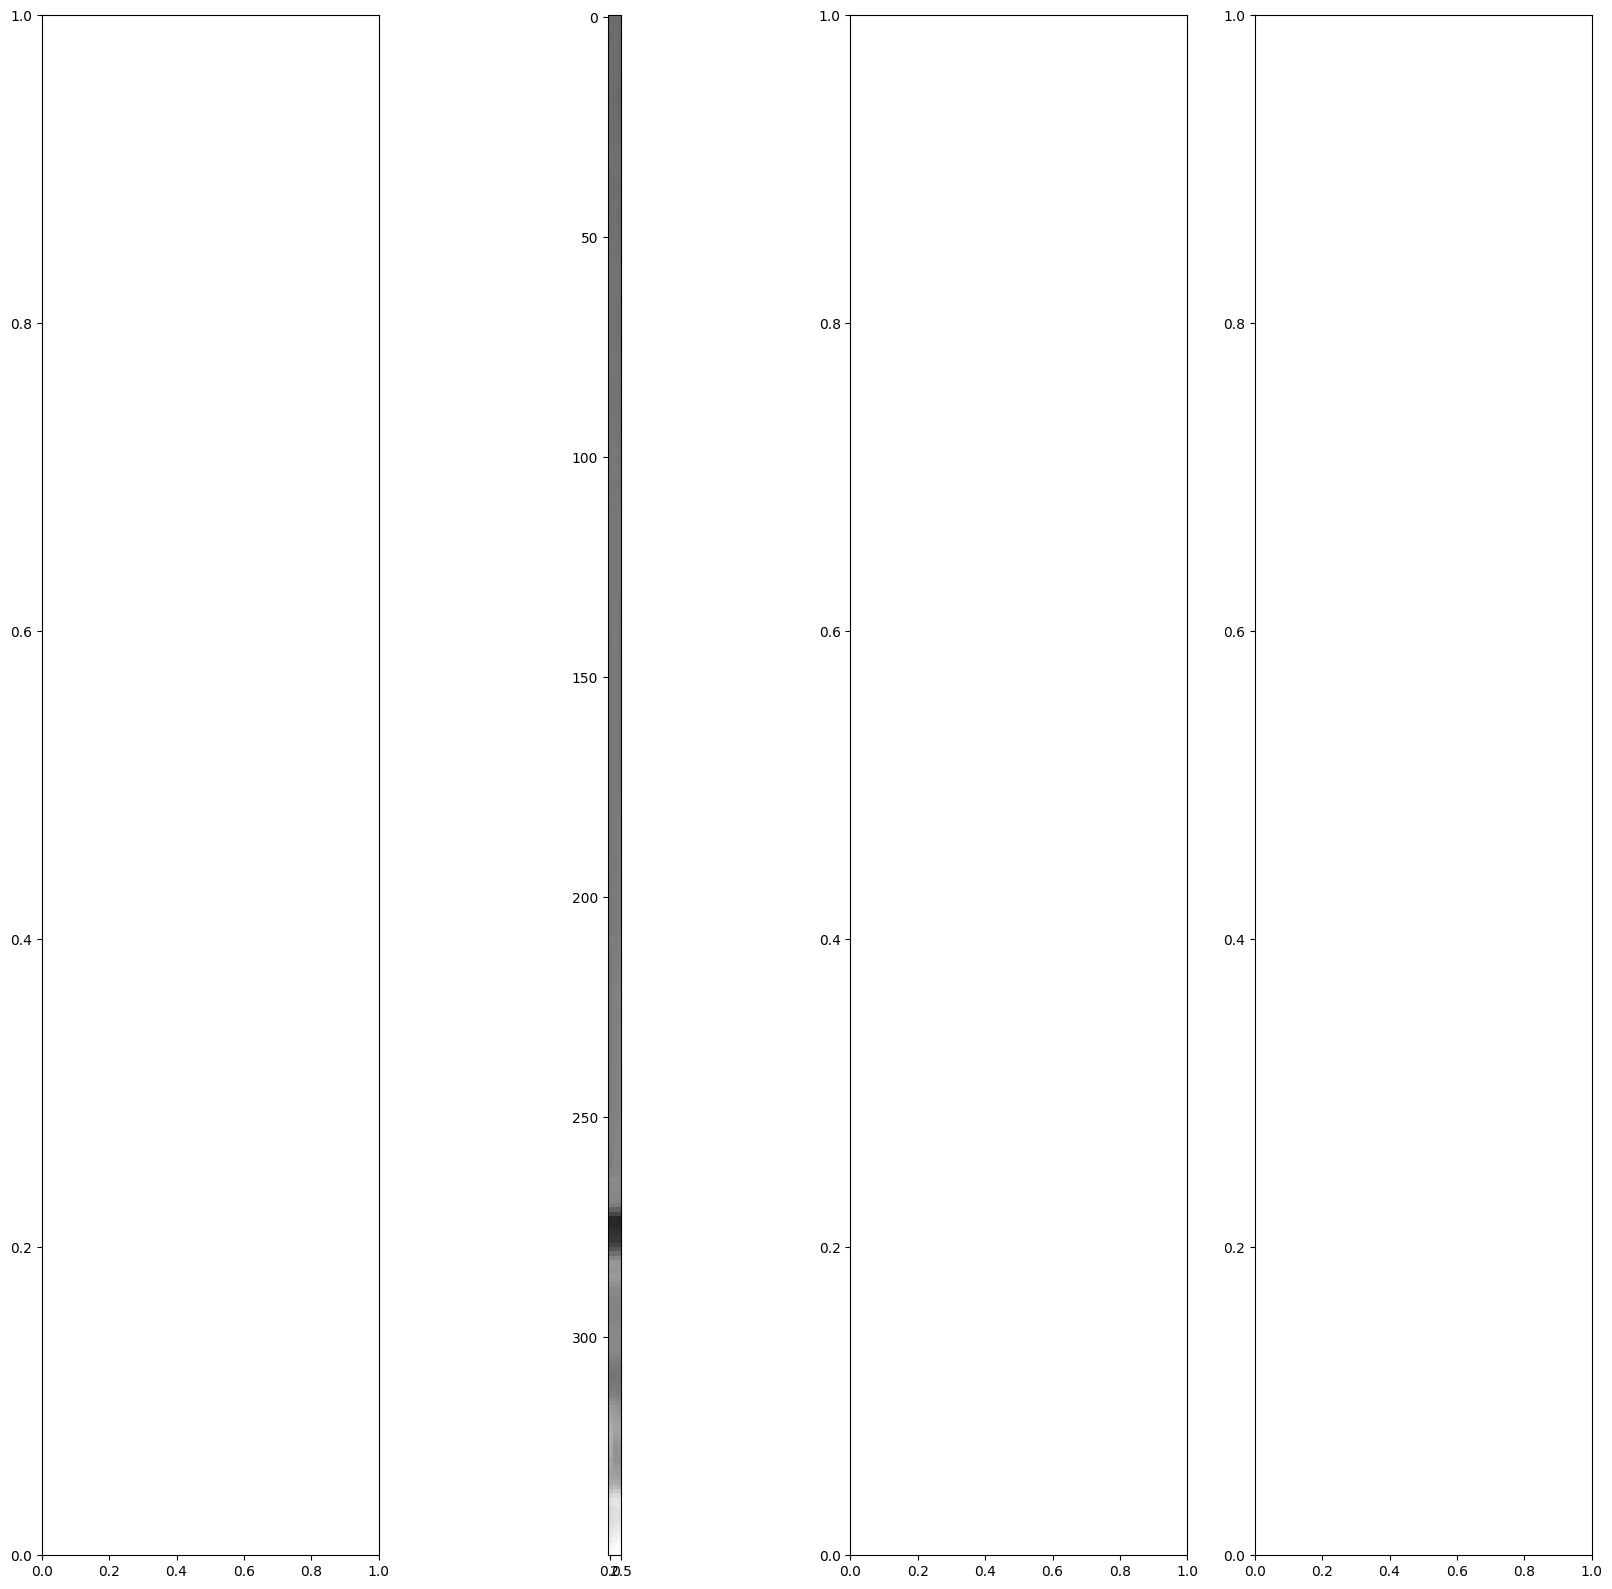

In [ ]:
# Get the first batch of data
data_samples = [ds.take(1).as_numpy_iterator() for ds in train]
res = [next(sample) for sample in data_samples]

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    # Get the image and bounding boxes from the first batch of the first class
    sample_image = res[0][0][idx]
    sample_bboxes = res[0][1][idx]

    # Create a copy of the image for drawing
    image_to_draw = sample_image.copy()

    for bbox in sample_bboxes:
        # Get the coordinates and class label from the bounding box
        coords = bbox[:4]
        class_label = bbox[4]

        # Draw a rectangle on the image using the coordinates
        cv2.rectangle(
            image_to_draw,
            tuple(np.multiply(coords[:2], [120, 120]).astype(int)),
            tuple(np.multiply(coords[2:], [120, 120]).astype(int)),
            (255, 0, 0),
            1,
        )

    # Display the image with the rectangles
    ax[idx].imshow(image_to_draw)

## 8. Build Deep Learning Using the Functional API

### 8.1 Import Layers and Base Network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [ ]:
vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build Instance of Network

In [ ]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation="relu")(f1)
    class2 = Dense(1, activation="sigmoid")(class1)
    
    # Bounding Box Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation="relu")(f2)
    regress2 = Dense(4, activation="sigmoid")(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [ ]:
train.as_numpy_iterator().next()[1]

AttributeError: 'list' object has no attribute 'as_numpy_iterator'

### 8.4 Test Out Neural Network

In [ ]:
facetracker = build_model()

In [ ]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker.predict(X)

In [ ]:
classes, coords

(array([[0.4233903 ],
        [0.44229937],
        [0.47946256],
        [0.45881218],
        [0.46080974],
        [0.40296835],
        [0.4338692 ],
        [0.38164872]], dtype=float32),
 array([[0.50946814, 0.49818313, 0.35306707, 0.52796084],
        [0.53446084, 0.49942458, 0.35391185, 0.6002043 ],
        [0.43694273, 0.52197844, 0.31023115, 0.4294694 ],
        [0.50065404, 0.5082981 , 0.43990156, 0.57842225],
        [0.45778885, 0.50052106, 0.27677384, 0.5398277 ],
        [0.5006635 , 0.49731195, 0.26902378, 0.48614708],
        [0.4423544 , 0.54127854, 0.30569145, 0.5016507 ],
        [0.47195306, 0.49436718, 0.37256163, 0.5594085 ]], dtype=float32))

## 9. Define Losses and Optimizer

### 9.1 Define Optimizer and LR

In [ ]:
len(train)

473

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/batches_per_epoch # Seberapa banyak learning rate drop setiap kali setelah 1x epoch

In [ ]:
lr_decay

0.0007047216349541929

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [ ]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_predict = yhat[:,3] - yhat[:,1]
    w_predict = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_predict) + tf.square(h_true - h_predict))

    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test Out Loss Metrics

In [ ]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.7667875>

In [ ]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7847817>

In [ ]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.7667875>

## 10. Train Neural Network

### 10.1 Create Custom Model Class

In [ ]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            y_class = tf.reshape(y[0], (-1, 1))  # Reshape to (batch_size, 1)
            batch_classloss = self.closs(y_class, classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_regressloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_regressloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_regressloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [ ]:
logdir = "logs"

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
473/473 [==============================] - 26s 46ms/step - total_loss: 0.2025 - class_loss: 0.0692 - regress_loss: 0.1679 - val_total_loss: 0.0948 - val_class_loss: 0.0485 - val_regress_loss: 0.0705
Epoch 2/40
473/473 [==============================] - 24s 45ms/step - total_loss: 0.1234 - class_loss: 0.0400 - regress_loss: 0.1035 - val_total_loss: 0.0184 - val_class_loss: 6.5166e-04 - val_regress_loss: 0.0181
Epoch 3/40
473/473 [==============================] - 25s 45ms/step - total_loss: 0.0701 - class_loss: 0.0268 - regress_loss: 0.0566 - val_total_loss: 0.0248 - val_class_loss: 0.0018 - val_regress_loss: 0.0240
Epoch 4/40
473/473 [==============================] - 24s 46ms/step - total_loss: 0.0569 - class_loss: 0.0182 - regress_loss: 0.0479 - val_total_loss: 0.0070 - val_class_loss: 8.8249e-05 - val_regress_loss: 0.0069
Epoch 5/40
473/473 [==============================] - 24s 46ms/step - total_loss: 0.0412 - class_loss: 0.0122 - regress_loss: 0.0351 - val_total_loss: 0

### 10.3 Plot Performance

In [ ]:
hist.history

{'total_loss': [0.049824364483356476,
  0.006560781970620155,
  0.005310442764312029,
  0.01944248005747795,
  0.0030177910812199116,
  0.013130486011505127,
  0.003008764237165451,
  0.003220546757802367,
  0.0012856894172728062,
  0.01713605225086212,
  0.0018783563282340765,
  0.005610797554254532,
  0.001959145301952958,
  0.000550829921849072,
  0.0018034183885902166,
  0.0011351682478561997,
  0.0043885610066354275,
  0.001378833083435893,
  0.0014567760517820716,
  0.0006844032905064523,
  0.0005413826438598335,
  0.0015075026312842965,
  0.00035080264206044376,
  0.0004125765699427575,
  0.000701323093380779,
  0.0027868261095136404,
  0.0009941983735188842,
  0.00020302138000261039,
  0.0005113313090987504,
  0.00012817526294384152,
  0.0010751825757324696,
  0.0007568912114948034,
  0.0007594966446049511,
  0.00025555293541401625,
  0.00022102460206951946,
  0.0006581980269402266,
  0.00041159274405799806,
  0.00011328669643262401,
  0.00031272132764570415,
  0.00106425967533

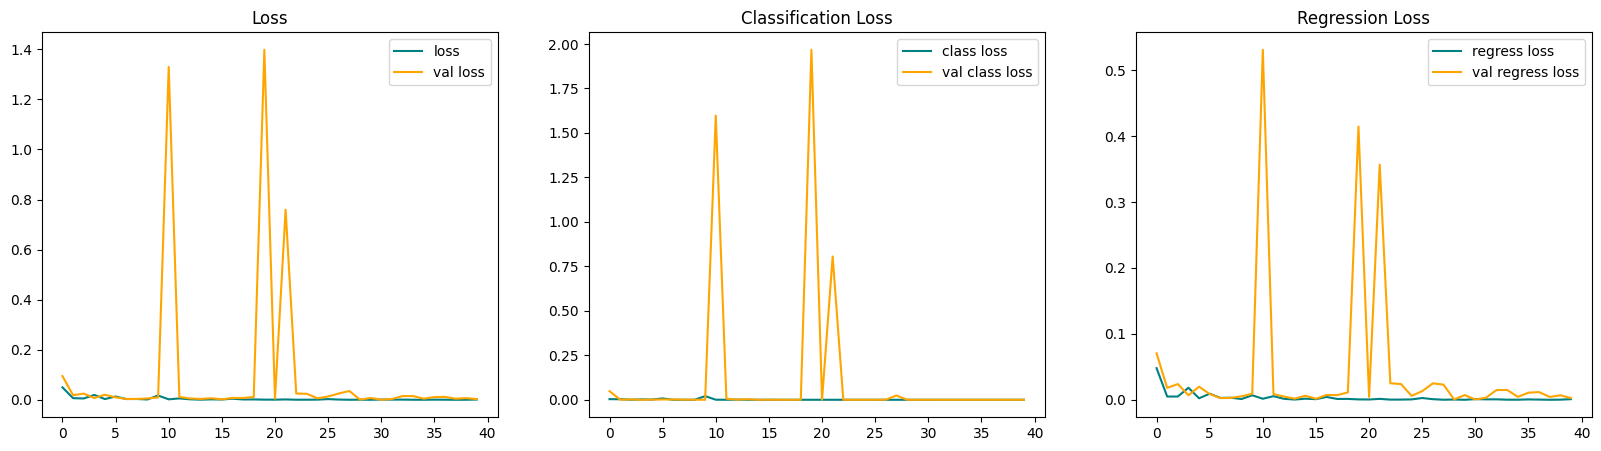

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history["total_loss"], color="teal", label="loss")
ax[0].plot(hist.history["val_total_loss"], color="orange", label="val loss")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(hist.history["class_loss"], color="teal", label="class loss")
ax[1].plot(hist.history["val_class_loss"], color="orange", label="val class loss")
ax[1].title.set_text("Classification Loss")
ax[1].legend()

ax[2].plot(hist.history["regress_loss"], color="teal", label="regress loss")
ax[2].plot(hist.history["val_regress_loss"], color="orange", label="val regress loss")
ax[2].title.set_text("Regression Loss")
ax[2].legend()

plt.show()

## 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


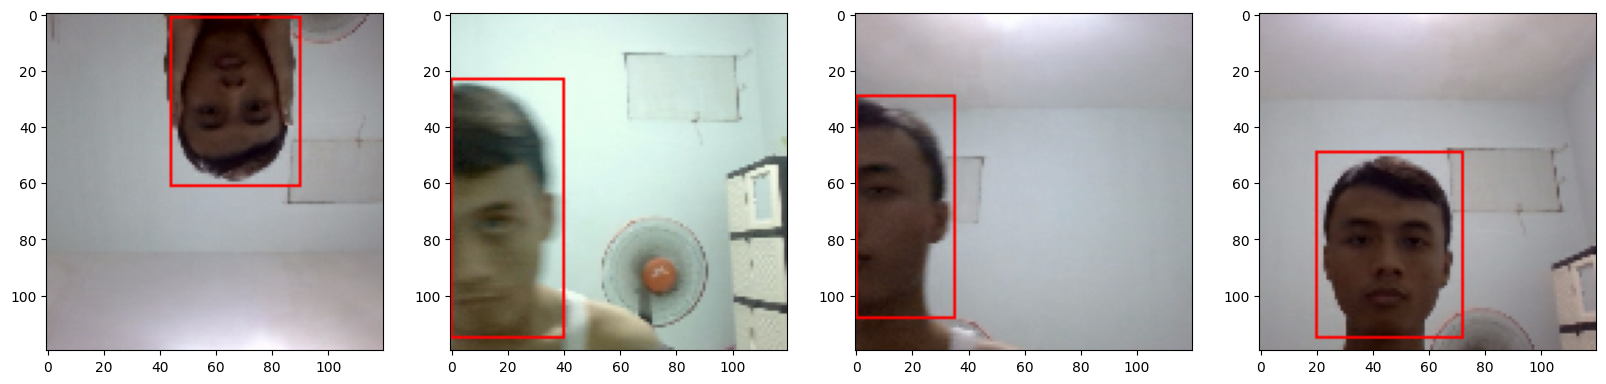

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    image_to_draw = sample_image.copy()

    if yhat[0][idx] > 0.7:
        cv2.rectangle(
            image_to_draw,
            tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
            tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
            (255, 0, 0),
            1,
        )

    ax[idx].imshow(image_to_draw)

### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save("facetracker.h5")

In [ ]:
facetracker = load_model("facetracker.h5")

### 11.3 Real Time Detection

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

In [ ]:
cap = cv2.VideoCapture(1)

while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.7:
        # Controls the Main Rectangle
        cv2.rectangle(
            frame,
            tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
            tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
            (255, 0, 0),
            1,
        )

        # Controls the Label Rectangle
        cv2.rectangle(
            frame,
            tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -30])),
            tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [80, 0])),
            (255, 0, 0),
            -1,
        )

        # Controls the Text Rendered
        cv2.putText(
            frame,
            "Face",
            tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -5])),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA
        )

    cv2.imshow("EyeTrack", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()